In [ ]:
import tensorflow as tf
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline
tf.random.set_seed(1234)

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.path.insert(1,'/content/drive/MyDrive/')
from data_utils import parse_imdb_sequence

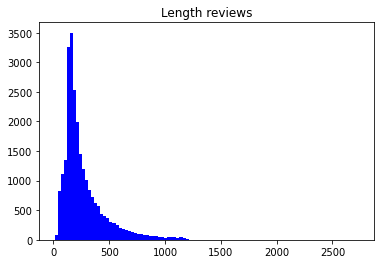

In [ ]:
length_reviews = pickle.load(open('/content/drive/MyDrive/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

In [ ]:
train_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/train.tfrecords')
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(512, padded_shapes=([None],[],[]))

val_dataset = train_dataset.skip(int(0.8*49))
train_dataset = train_dataset.take(int(0.8*49))

test_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [ ]:
# Read the word vocabulary
word2idx = pickle.load(open('/content/drive/MyDrive/word2idx.pkl', 'rb'))

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break    

    def compute_accuracy(self, test_data):
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        test_acc = tf.keras.metrics.Accuracy('test_acc')
        
        # Begin training
        with tf.device(self.device):

            # Check accuracy eval dataset
            for step, (X, y, seq_length) in enumerate(test_data):
                logits = self.predict(X, seq_length, False)
                preds = tf.argmax(logits, axis=1)
                test_acc(preds, y)

            print(test_acc.result().numpy())                     

LSTM CELL

In [ ]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [ ]:
# Train model
lstm_model.fit(train_dataset, val_dataset, optimizer, num_epochs=10, early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.681891
Eval accuracy at epoch 1:  0.67031
Train accuracy at epoch 2:  0.7917668
Eval accuracy at epoch 2:  0.78895074
Train accuracy at epoch 3:  0.83488584
Eval accuracy at epoch 3:  0.8277027
Train accuracy at epoch 4:  0.900641
Eval accuracy at epoch 4:  0.8930843
Train accuracy at epoch 5:  0.9251302
Eval accuracy at epoch 5:  0.92607313
Train accuracy at epoch 6:  0.94426084
Eval accuracy at epoch 6:  0.9356121
Train accuracy at epoch 7:  0.95863384
Eval accuracy at epoch 7:  0.95528615
Train accuracy at epoch 8:  0.9679988
Eval accuracy at epoch 8:  0.9626391
Train accuracy at epoch 9:  0.96719754
Eval accuracy at epoch 9:  0.96144676
Train accuracy at epoch 10:  0.97936696
Eval accuracy at epoch 10:  0.9741653


GRU CELL

In [ ]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
gru_model = RNNModel(vocabulary_size=len(word2idx), 
                       device=device, checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.


In [ ]:
gru_model.fit(train_dataset, val_dataset, optimizer, num_epochs=10, early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.5348558
Eval accuracy at epoch 1:  0.5339825
Train accuracy at epoch 2:  0.55453724
Eval accuracy at epoch 2:  0.5522655
Train accuracy at epoch 3:  0.7171474
Eval accuracy at epoch 3:  0.71780604
Train accuracy at epoch 4:  0.81355166
Eval accuracy at epoch 4:  0.8106121
Train accuracy at epoch 5:  0.8676883
Eval accuracy at epoch 5:  0.8672496
Train accuracy at epoch 6:  0.89758617
Eval accuracy at epoch 6:  0.89924484
Train accuracy at epoch 7:  0.91561496
Eval accuracy at epoch 7:  0.91136724
Train accuracy at epoch 8:  0.91215944
Eval accuracy at epoch 8:  0.9101749
Train accuracy at epoch 9:  0.93729967
Eval accuracy at epoch 9:  0.9346184
Train accuracy at epoch 10:  0.94946915
Eval accuracy at epoch 10:  0.9459459


Performance comparison

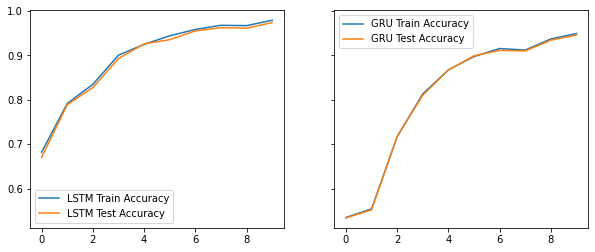

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['eval_acc'])), lstm_model.history['eval_acc'], 
         label='LSTM Test Accuracy');
ax2.plot(range(len(gru_model.history['train_acc'])), gru_model.history['train_acc'],
         label='GRU Train Accuracy');
ax2.plot(range(len(gru_model.history['eval_acc'])), gru_model.history['eval_acc'],
         label='GRU Test Accuracy');
ax1.legend();
ax2.legend();
plt.savefig('Performance plots.jpg',dpi=400)

Test network

In [ ]:
gru_model.compute_accuracy(test_dataset)

0.88352
